# Point spread function covariance

In order to use the NLL with a MVG distribution, the assumption was that the covariance $\Sigma$ of the model was Identity in its representation, essentially for $\Sigma\in\mathbb{R}^{22500x22500}$, the matrix was represented as $\text{diag(1,1,...,1)}$

This assumption works for data (pixels) that are i.i.d, however in Radio astronomy, this is not the case. Data are read in as fourier components, and during processing are convolved, this leads to *point spread*, where point sources have been smeared across multiple pixels. We know from [the webiste](https://sundog.stsci.edu/first/catalogs/readme.html) that VLA-FIRST, where RGZ108k (dataset used is from) has a point spread of 1.8 arcseeconds. This means that each pixel represents a distance $\mathbf{x}$ of $(\text{RA},\delta)=(1.8,1.8)$. We also know the point-spread in the north,south is 5.4,6.4.

## Assumptions:

- We will do away with the 6.4, and assume the point-spread distribution is governed only by the 5.4, which gives the point spread $p(x)\sim \mathcal{N}(x;0,\sigma^2)$ wheere $\sigma=\frac{5.4}{2\sqrt{2\ln{2}}}$
- While calculations of distrance in $(\text{RA},\delta)$ can be done, for ease the calculation will be done for demonstration in Euclidean space $(x,y)$, allowing to take the $L_2$ norm.

The algorithm can be thought of as, for two pixels in an image $(i,j)$,$(k,l)$:
$$
d_{(i,j),(k,l)} = 1.8\sqrt{(i-k)^2+(j-l)^2}
$$

This results in a correlation:

$$
C_{(i,j),(k,l)} = \mathcal{N}(d;0,\sigma^2)
$$

The implementation is followed:

In [1]:
import numpy as np
from scipy.stats import norm

image_size = 150
sigma = 5.4 / (2 * np.sqrt(2 * np.log(2)))
normal = norm(loc=0,scale=sigma)

x, y = np.meshgrid(np.arange(image_size), np.arange(image_size), indexing="ij")
pixel_coords = np.stack((x.ravel(), y.ravel()), axis=1)

pixels = image_size**2
correlation_matrix = np.zeros((pixels,pixels))

```
for q in range(pixels):
    i,j = pixel_coords[q]
    for r in range(pixels):
        if q == r: # Diagonal entries
            correlation_matrix[q,r]=1
        else:
            k,l = pixel_coords[r] # For pixel 2
            d =  d = np.sqrt((i - k) ** 2 + (j - l) ** 2)
            C = normal.pdf(d)
            correlation_matrix[q,r] = C
```

Killed at 2.5 mins

```
for q in range(pixels):
    i,j = pixel_coords[q]
    for r in range(pixels):
        if q == r: # Diagonal entries
            correlation_matrix[q,r]=1
        else:
            k,l = pixel_coords[r] # For pixel 2
            d = np.sqrt((i - k) ** 2 + (j - l) ** 2)
            C = 1/(np.sqrt(np.pi * 2 * sigma))* np.exp(-np.power(d,2)/(2*sigma**2))
            correlation_matrix[q,r] = C
```

Killed after 10 minutes

Try calculating C in a vectorised way

In [2]:
i, j = pixel_coords[:, 0], pixel_coords[:, 1] 

di = i[:, None] - i[None, :] # Difference in x for all coordinates
dj = j[:, None] - j[None, :] # Difference in y for all coordinats
d = 1.8*np.sqrt(di**2 + dj**2) # d[x,x'] difference in euclidean distance between the two pixels in the (RA,\delta) ~ Euclidean R^{22500 \otimes 22500}

C= (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-d**2 / (2 * sigma**2)) # Just the N(0,sigma^2)

# Set the diagonal elements to 1
np.fill_diagonal(C, 1)

# Assign the result
correlation_matrix = C


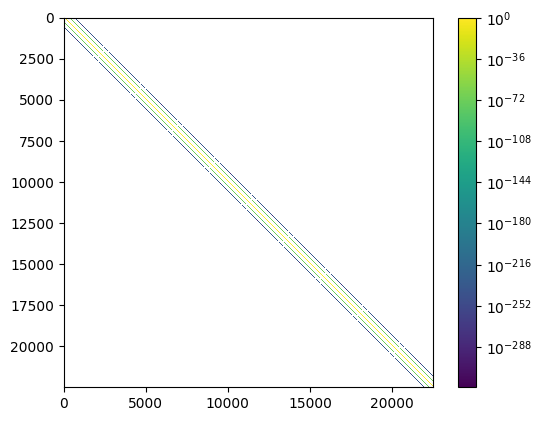

In [3]:
import matplotlib.pyplot as plt
plt.imshow(correlation_matrix, cmap='viridis', interpolation='nearest',norm="log")
plt.colorbar()  # Add color scale
plt.show()

Correlation Drops off massively (expected)

### Example use case with PyTorch

In [ ]:
import torch
def find_correlation_matrix(image_size,sigma):
    """
    - Inputs:
        - image_size: data dimensionality
        - sigma: standard deviation of the target distribution.
    """
    x, y = np.meshgrid(np.arange(image_size), np.arange(image_size), indexing="ij")
    pixel_coords = np.stack((x.ravel(), y.ravel()), axis=1)
    i, j = pixel_coords[:, 0], pixel_coords[:, 1] 

    di = i[:, None] - i[None, :] # Difference in x for all coordinates
    dj = j[:, None] - j[None, :] # Difference in y for all coordinats
    d = 1.8*np.sqrt(di**2 + dj**2) # d[x,x'] difference in euclidean distance between the two pixels in the (RA,\delta) ~ Euclidean R^{22500 \otimes 22500}

    C= (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-d**2 / (2 * sigma**2)) # Just the N(0,sigma^2)

    # Set the diagonal elements to 1
    np.fill_diagonal(C, 1)

    # Assign the result
    correlation_matrix = C
    return correlation_matrix
correlation_matrix = find_correlation_matrix(image_size, sigma)
correlation_matrix = torch.tensor(correlation_matrix, dtype=torch.float32)
